# Data Augmentation

### Goals
In this notebook you're going to build a generator that can be used to help create data to train a classifier. There are many cases where this might be useful. If you are interested in any of these topics, you are welcome to explore the linked papers and articles! 

-   With smaller datasets, GANs can provide useful data augmentation that substantially [improve classifier performance](https://arxiv.org/abs/1711.04340). 
-   You have one type of data already labeled and would like to make predictions on [another related dataset for which you have no labels](https://www.nature.com/articles/s41598-019-52737-x). (You'll learn about the techniques for this use case in future notebooks!)
-   You want to protect the privacy of the people who provided their information so you can provide access to a [generator instead of real data](https://www.ahajournals.org/doi/full/10.1161/CIRCOUTCOMES.118.005122). 
-   You have [input data with many missing values](https://arxiv.org/abs/1806.02920), where the input dimensions are correlated and you would like to train a model on complete inputs. 
-   You would like to be able to identify a real-world abnormal feature in an image [for the purpose of diagnosis](https://link.springer.com/chapter/10.1007/978-3-030-00946-5_11), but have limited access to real examples of the condition. 

In this assignment, you're going to be acting as a bug enthusiast — more on that later. 

### Learning Objectives
1.   Understand some use cases for data augmentation and why GANs suit this task.
2.   Implement a classifier that takes a mixed dataset of reals/fakes and analyze its accuracy.

## Getting Started

### Data Augmentation
Before you implement GAN-based data augmentation, you should know a bit about data augmentation in general, specifically for image datasets. It is [very common practice](https://arxiv.org/abs/1712.04621) to augment image-based datasets in ways that are appropriate for a given dataset. This may include having your dataloader randomly flipping images across their vertical axis, randomly cropping your image to a particular size, randomly adding a bit of noise or color to an image in ways that are true-to-life. 

In general, data augmentation helps to stop your model from overfitting to the data, and allows you to make small datasets many times larger. However, a sufficiently powerful classifier often still overfits to the original examples which is why GANs are particularly useful here. They can generate new images instead of simply modifying existing ones.

### CIFAR
The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) datasets are extremely widely used within machine learning -- they contain many thousands of “tiny” 32x32 color images of different classes representing relatively common real-world objects like airplanes and dogs, with 10 classes in CIFAR-10 and 100 classes in CIFAR-100. In CIFAR-100, there are 20 “superclasses” which each contain five classes. For example, the “fish” superclass contains “aquarium fish, flatfish, ray, shark, trout”. For the purposes of this assignment, you’ll be looking at a small subset of these images to simulate a small data regime, with only 40 images of each class for training.

![alt text](CIFAR.png)

### Initializations
You will begin by importing some useful libraries and packages and defining a visualization function that has been provided. You will also be re-using your conditional generator and functions code from earlier assignments. This will let you control what class of images to augment for your classifier.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

#### Generator

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CIFAR100 is in color (red, green, blue), so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4, kernel_size=4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=2, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?)
    Parameters:
    x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
    y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    return torch.cat([x, y], 1)

def get_one_hot_labels(labels, n_classes):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?)
    Parameters:
    labels: (n_samples, 1) 
    n_classes: a single integer corresponding to the total number of classes in the dataset
    '''
    return F.one_hot(labels, n_classes)

## Training
Now you can begin training your models.
First, you will define some new parameters:

*   cifar100_shape: the number of pixels in each CIFAR image, which has dimensions 32 x 32 and three channel (for red, green, and blue) so 3 x 32 x 32
*   n_classes: the number of classes in CIFAR100 (e.g. airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)

In [3]:
cifar100_shape = (3, 32, 32)
n_classes = 100

And you also include the same parameters from previous assignments:

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type

In [4]:
n_epochs = 10000
z_dim = 64
display_step = 500
batch_size = 64
lr = 0.0002
device = 'cuda'

Then, you want to set your generator's input dimension. Recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector.

In [5]:
generator_input_dim = z_dim + n_classes

#### Classifier

For the classifier, you will use the same code that you wrote in an earlier assignment (the same as previous code for the discriminator as well since the discriminator is a real/fake classifier).

In [6]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels of the output image, a scalar
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan, n_classes, hidden_dim=32):
        super(Classifier, self).__init__()
        self.disc = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.disc(image)
        return class_pred.view(len(class_pred), -1)

#### Pre-training (Optional)

You are provided the code to pre-train the models (GAN and classifier) given to you in this assignment. However, this is intended only for your personal curiosity -- for the assignment to run as intended, you should not use any checkpoints besides the ones given to you.

In [7]:
# This code is here for you to train your own generator or classifier 
# outside the assignment on the full dataset if you'd like -- for the purposes 
# of this assignment, please use the provided checkpoints
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim, stride=1),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

def train_generator():
    gen = Generator(generator_input_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    discriminator_input_dim = cifar100_shape[0] + n_classes
    disc = Discriminator(discriminator_input_dim).to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

    criterion = nn.BCEWithLogitsLoss()
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for epoch in range(n_epochs):
        # Dataloader returns the batches and the labels
        for real, labels in dataloader:
            cur_batch_size = len(real)
            # Flatten the batch of real images from the dataset
            real = real.to(device)

            # Convert the labels from the dataloader into one-hot versions of those labels
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, cifar100_shape[1], cifar100_shape[2])

            ### Update discriminator ###
            # Zero out the discriminator gradients
            disc_opt.zero_grad()
            # Get noise corresponding to the current batch_size 
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
            # Combine the vectors of the noise and the one-hot labels for the generator
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)
            # Combine the vectors of the images and the one-hot labels for the discriminator
            fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            disc_real_pred = disc(real_image_and_labels)

            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step() 

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step

            ### Update generator ###
            # Zero out the generator gradients
            gen_opt.zero_grad()

            # Pass the discriminator the combination of the fake images and the one-hot labels
            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()

            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(fake)
                show_tensor_images(real)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            cur_step += 1

def train_classifier():
    criterion = nn.CrossEntropyLoss()
    n_epochs = 10

    validation_dataloader = DataLoader(
        CIFAR100(".", train=False, download=True, transform=transform),
        batch_size=batch_size)

    display_step = 10
    batch_size = 512
    lr = 0.0002
    device = 'cuda'
    classifier = Classifier(cifar100_shape[0], n_classes).to(device)
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)
    cur_step = 0
    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            real = real.to(device)
            labels = labels.to(device)

            ### Update classifier ###
            # Get noise corresponding to the current batch_size
            classifier_opt.zero_grad()
            labels_hat = classifier(real.detach())
            classifier_loss = criterion(labels_hat, labels)
            classifier_loss.backward()
            classifier_opt.step()

            if cur_step % display_step == 0:
                classifier_val_loss = 0
                classifier_correct = 0
                num_validation = 0
                for val_example, val_label in validation_dataloader:
                    cur_batch_size = len(val_example)
                    num_validation += cur_batch_size
                    val_example = val_example.to(device)
                    val_label = val_label.to(device)
                    labels_hat = classifier(val_example)
                    classifier_val_loss += criterion(labels_hat, val_label) * cur_batch_size
                    classifier_correct += (labels_hat.argmax(1) == val_label).float().sum()

                print(f"Step {cur_step}: "
                        f"Classifier loss: {classifier_val_loss.item() / num_validation}, "
                        f"classifier accuracy: {classifier_correct.item() / num_validation}")
            cur_step += 1


## Tuning the Classifier
After two courses, you've probably had some fun debugging your GANs and have started to consider yourself a bug master. For this assignment, your mastery will be put to the test on some interesting bugs... well, bugs as in insects.

As a bug master, you want a classifier capable of classifying different species of bugs: bees, beetles, butterflies, caterpillar, and more. Luckily, you found a great dataset with a lot of animal species and objects, and you trained your classifier on that.

But the bug classes don't do as well as you would like. Now your plan is to train a GAN on the same data so it can generate new bugs to make your classifier better at distinguishing between all of your favorite bugs!

You will fine-tune your model by augmenting the original real data with fake data and during that process, observe how to increase the accuracy of your classifier with these fake, GAN-generated bugs. After this, you will prove your worth as a bug master.

#### Sampling Ratio

Suppose that you've decided that although you have this pre-trained general generator and this general classifier, capable of identifying 100 classes with some accuracy (~17%), what you'd really like is a model that can classify the five different kinds of bugs in the dataset. You'll fine-tune your model by augmenting your data with the generated images. Keep in mind that both the generator and the classifier were trained on the same images: the 40 images per class you painstakingly found so your generator may not be great. This is the caveat with data augmentation, ultimately you are still bound by the real data that you have but you want to try and create more. To make your models even better, you would need to take some more bug photos, label them, and add them to your training set and/or use higher quality photos.

To start, you'll first need to write some code to sample a combination of real and generated images. Given a probability, `p_real`, you'll need to generate a combined tensor where roughly `p_real` of the returned images are sampled from the real images. Note that you should not interpolate the images here: you should choose each image from the real or fake set with a given probability. For example, if your real images are a tensor of `[[1, 2, 3, 4, 5]]` and your fake images are a tensor of `[[-1, -2, -3, -4, -5]]`, and `p_real = 0.2`, two potential return values are `[[1, -2, 3, -4, -5]]` or `[[-1, 2, -3, -4, -5]]`

In addition, we will expect the images to remain in the same order to maintain their alignment with their labels (this applies to the fake images too!). 

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">combine_sample</font></code></b>
</font>
</summary>

1.   This code probably shouldn't be much longer than 3 lines
2.   You can index using a set of booleans which have the same length as your tensor
3.   You want to generate an unbiased sample, which you can do (for example) with `torch.rand(length_reals) > p`.
4.   There are many approaches here that will give a correct answer here. You may find [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html) or [`torch.bernoulli`](https://pytorch.org/docs/master/generated/torch.bernoulli.html) useful. 
5.   You don't want to edit an argument in place, so you may find [`cur_tensor.clone()`](https://pytorch.org/docs/stable/tensors.html) useful too, which makes a copy of `cur_tensor`. 

</details>

In [23]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: combine_sample
def combine_sample(real, fake, p_real):
    '''
    Function to take a set of real and fake images of the same length (x)
    and produce a combined tensor with length (x) and sampled at the target probability
    Parameters:
        real: a tensor of real images, length (x)
        fake: a tensor of fake images, length (x)
        p_real: the probability the images are sampled from the real set
    '''
    #### START CODE HERE ####
    probs = torch.rand(real.shape[0]) > p_real
    target_images = real.clone()
    target_images[probs] = fake[probs]
    #### END CODE HERE ####
    return target_images

In [24]:
n_test_samples = 9999
test_combination = combine_sample(
    torch.ones(n_test_samples, 1), 
    torch.zeros(n_test_samples, 1), 
    0.3
)
# Check that the shape is right
assert tuple(test_combination.shape) == (n_test_samples, 1)
# Check that the ratio is right
assert torch.abs(test_combination.mean() - 0.3) < 0.05
# Make sure that no mixing happened
assert test_combination.median() < 1e-5

test_combination = combine_sample(
    torch.ones(n_test_samples, 10, 10), 
    torch.zeros(n_test_samples, 10, 10), 
    0.8
)
# Check that the shape is right
assert tuple(test_combination.shape) == (n_test_samples, 10, 10)
# Make sure that no mixing happened
assert torch.abs((test_combination.sum([1, 2]).median()) - 100) < 1e-5

test_reals = torch.arange(n_test_samples)[:, None].float()
test_fakes = torch.zeros(n_test_samples, 1)
test_saved = (test_reals.clone(), test_fakes.clone())
test_combination = combine_sample(test_reals, test_fakes, 0.3)
# Make sure that the sample isn't biased
assert torch.abs((test_combination.mean() - 1500)) < 100
# Make sure no inputs were changed
assert torch.abs(test_saved[0] - test_reals).sum() < 1e-3
assert torch.abs(test_saved[1] - test_fakes).sum() < 1e-3

test_fakes = torch.arange(n_test_samples)[:, None].float()
test_combination = combine_sample(test_reals, test_fakes, 0.3)
# Make sure that the order is maintained
assert torch.abs(test_combination - test_reals).sum() < 1e-4
if torch.cuda.is_available():
    # Check that the solution matches the input device
    assert str(combine_sample(
        torch.ones(n_test_samples, 10, 10).cuda(), 
        torch.zeros(n_test_samples, 10, 10).cuda(),
        0.8
    ).device).startswith("cuda")
print("Success!")

Success!


Now you have a challenge: find a `p_real` and a generator image such that your classifier gets an average of a 51% accuracy or higher on the insects, when evaluated with the `eval_augmentation` function. **You'll need to fill in `find_optimal` to find these parameters to solve this part!** Note that if your answer takes a very long time to run, you may need to hard-code the solution it finds. 

When you're training a generator, you will often have to look at different checkpoints and choose one that does the best (either empirically or using some evaluation method). Here, you are given four generator checkpoints: `gen_1.pt`, `gen_2.pt`, `gen_3.pt`, `gen_4.pt`. You'll also have some scratch area to write whatever code you'd like to solve this problem, but you must return a `p_real` and an image name of your selected generator checkpoint. You can hard-code/brute-force these numbers if you would like, but you are encouraged to try to solve this problem in a more general way. In practice, you would also want a test set (since it is possible to overfit on a validation set), but for simplicity you can just focus on the validation set.

In [32]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: find_optimal
def find_optimal():
    # In the following section, you can write the code to choose your optimal answer
    # You can even use the eval_augmentation function in your code if you'd like!
    gen_names = [
        "gen_1.pt",
        "gen_2.pt",
        "gen_3.pt",
        "gen_4.pt"
    ]

    #### START CODE HERE #### 
    best_p_real, best_gen_name = 0.65, "gen_4.pt"
#     best_score = -1000000000
#     for gen in tqdm(gen_names):
#         probable_ps = torch.linspace(0, 1, 21)
#         for ps in probable_ps:
#             curr_score = eval_augmentation(ps, gen)
#             if curr_score > best_score:
#                 best_score = curr_score
#                 best_p_real = ps
#                 best_gen_name = gen
    #### END CODE HERE ####
#     print(best_p_real, best_gen_name)
    return best_p_real, best_gen_name

def augmented_train(p_real, gen_name):
    gen = Generator(generator_input_dim).to(device)
    gen.load_state_dict(torch.load(gen_name))

    classifier = Classifier(cifar100_shape[0], n_classes).to(device)
    classifier.load_state_dict(torch.load("class.pt"))
    criterion = nn.CrossEntropyLoss()
    batch_size = 256

    train_set = torch.load("insect_train.pt")
    val_set = torch.load("insect_val.pt")
    dataloader = DataLoader(
        torch.utils.data.TensorDataset(train_set["images"], train_set["labels"]),
        batch_size=batch_size,
        shuffle=True
    )
    validation_dataloader = DataLoader(
        torch.utils.data.TensorDataset(val_set["images"], val_set["labels"]),
        batch_size=batch_size
    )

    display_step = 1
    lr = 0.0002
    n_epochs = 20
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)
    cur_step = 0
    best_score = 0
    for epoch in range(n_epochs):
        for real, labels in dataloader:
            real = real.to(device)
            # Flatten the image
            labels = labels.to(device)
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            ### Update classifier ###
            # Get noise corresponding to the current batch_size
            classifier_opt.zero_grad()
            cur_batch_size = len(labels)
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)

            target_images = combine_sample(real.clone(), fake.clone(), p_real)
            labels_hat = classifier(target_images.detach())
            classifier_loss = criterion(labels_hat, labels)
            classifier_loss.backward()
            classifier_opt.step()

            # Calculate the accuracy on the validation set
            if cur_step % display_step == 0 and cur_step > 0:
                classifier_val_loss = 0
                classifier_correct = 0
                num_validation = 0
                with torch.no_grad():
                    for val_example, val_label in validation_dataloader:
                        cur_batch_size = len(val_example)
                        num_validation += cur_batch_size
                        val_example = val_example.to(device)
                        val_label = val_label.to(device)
                        labels_hat = classifier(val_example)
                        classifier_val_loss += criterion(labels_hat, val_label) * cur_batch_size
                        classifier_correct += (labels_hat.argmax(1) == val_label).float().sum()
                    accuracy = classifier_correct.item() / num_validation
                    if accuracy > best_score:
                        best_score = accuracy
            cur_step += 1
    return best_score

def eval_augmentation(p_real, gen_name, n_test=20):
    total = 0
    for i in range(n_test):
        total += augmented_train(p_real, gen_name)
    return total / n_test

best_p_real, best_gen_name = find_optimal()
performance = eval_augmentation(best_p_real, best_gen_name)
print(f"Your model had an accuracy of {performance:0.1%}")
assert performance > 0.512
print("Success!")

Your model had an accuracy of 51.8%
Success!


You'll likely find that the worst performance is when the generator is performing alone: this corresponds to the case where you might be trying to hide the underlying examples from the classifier. Perhaps you don't want other people to know about your specific bugs!

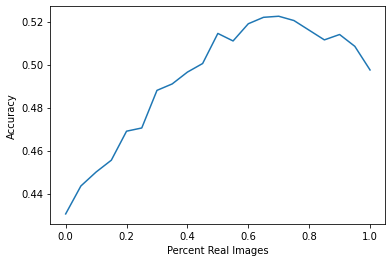

In [30]:
accuracies = []
p_real_all = torch.linspace(0, 1, 21)
for p_real_vis in tqdm(p_real_all):
    accuracies += [eval_augmentation(p_real_vis, best_gen_name, n_test=4)]
plt.plot(p_real_all.tolist(), accuracies)
plt.ylabel("Accuracy")
_ = plt.xlabel("Percent Real Images")

Here's a visualization of what the generator is actually generating, with real examples of each class above the corresponding generated image.  

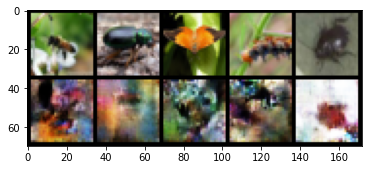

In [31]:
examples = [4, 41, 80, 122, 160]
train_images = torch.load("insect_train.pt")["images"][examples]
train_labels = torch.load("insect_train.pt")["labels"][examples]

one_hot_labels = get_one_hot_labels(train_labels.to(device), n_classes).float()
fake_noise = get_noise(len(train_images), z_dim, device=device)
noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
gen = Generator(generator_input_dim).to(device)
gen.load_state_dict(torch.load(best_gen_name))

fake = gen(noise_and_labels)
show_tensor_images(torch.cat([train_images.cpu(), fake.cpu()]))